In [27]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [28]:
def get_preprocessed_images(data_path):
    for folder in os.listdir(data_path):
        sub_path = os.path.join(data_path, folder)
        for file in os.listdir(sub_path):
            img_path = os.path.join(sub_path, file)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.resize(img_arr, (224, 224))
            yield img_arr

In [29]:
train_path = "../data/train"
test_path = "../data/test"
val_path = "../data/val"

train_x = np.array(list(get_preprocessed_images(train_path))) / 255.0
test_x = np.array(list(get_preprocessed_images(test_path))) / 255.0
val_x = np.array(list(get_preprocessed_images(val_path))) / 255.0

In [30]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [31]:
training_set = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode="sparse"
)

Found 550 images belonging to 2 classes.


In [32]:
test_set = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=32, class_mode="sparse"
)

Found 482 images belonging to 2 classes.


In [33]:
val_set = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode="sparse"
)

Found 161 images belonging to 2 classes.


In [34]:
train_y = training_set.classes
test_y = test_set.classes
val_y = val_set.classes

In [35]:
vgg = VGG19(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layer in vgg.layers:
    layer.trainable = False

In [36]:
x = Flatten()(vgg.output)
# adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(2, activation="softmax")(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [37]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Compiling the model

In [38]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Fitting the model

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Early stopping to avoid overfitting of model

In [40]:
# fit the model
history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs=10,
    callbacks=[early_stop],
    batch_size=32,
    shuffle=True,
)

Epoch 1/10
18/18 [==============================] - 103s 6s/step - loss: 1.2917 - accuracy: 0.6291 - val_loss: 0.9648 - val_accuracy: 0.5466
Epoch 2/10
18/18 [==============================] - 97s 5s/step - loss: 0.3289 - accuracy: 0.8527 - val_loss: 2.8028 - val_accuracy: 0.4348
Epoch 3/10
18/18 [==============================] - 95s 5s/step - loss: 0.2203 - accuracy: 0.8927 - val_loss: 1.1047 - val_accuracy: 0.5963
Epoch 4/10
18/18 [==============================] - 97s 5s/step - loss: 0.1495 - accuracy: 0.9418 - val_loss: 1.8821 - val_accuracy: 0.5342
Epoch 5/10
18/18 [==============================] - 92s 5s/step - loss: 0.0807 - accuracy: 0.9818 - val_loss: 1.7873 - val_accuracy: 0.5466
Epoch 6/10
18/18 [==============================] - 94s 5s/step - loss: 0.0462 - accuracy: 0.9909 - val_loss: 1.7616 - val_accuracy: 0.5466
Epoch 6: early stopping


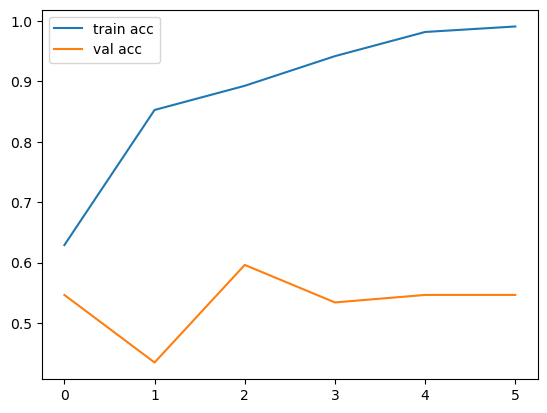

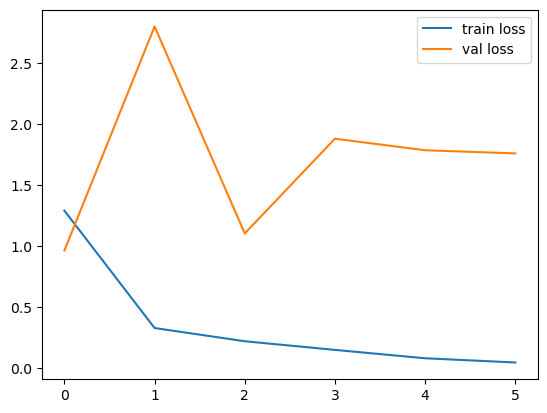

In [41]:
# accuracies

plt.plot(history.history["accuracy"], label="train acc")

plt.plot(history.history["val_accuracy"], label="val acc")

plt.legend()

plt.savefig("vgg-acc-rps-1.png")

plt.show()
# loss
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.savefig("vgg-loss-rps-1.png")
plt.show()

# Evaluate Model

In [42]:
model.evaluate(test_x, test_y, batch_size=32)

16/16 [==============================] - 68s 4s/step - loss: 1.3532 - accuracy: 0.6390


[1.353240728378296, 0.6390041708946228]

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# predict
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)
# get classification report
print(classification_report(y_pred, test_y))
# get confusion matrix
print(confusion_matrix(y_pred, test_y))

16/16 [==============================] - 58s 4s/step
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       294
           1       0.52      0.86      0.65       188

    accuracy                           0.64       482
   macro avg       0.69      0.68      0.64       482
weighted avg       0.72      0.64      0.64       482

[[146 148]
 [ 26 162]]
